In [1]:
### Mining restaurant order
import numpy as np 
import pandas as pd  # process data 
import matplotlib
import matplotlib.pyplot as plt #
import seaborn as sns  # statistical plotting
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, StandardScaler # Preprocessing

from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve, validation_curve, GridSearchCV  # Model 
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor 
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor  # Ensemble methods
from sklearn.svm import SVR  # 
from sklearn.tree import DecisionTreeRegressor # 
from sklearn.pipeline import Pipeline 
## reduce dimension
from sklearn.decomposition import KernelPCA, PCA #
from sklearn.feature_selection import SelectFromModel 

from sklearn.base import clone 
from sklearn.metrics import mean_squared_error as MSE
import random


In [14]:
df_bills  = pd.read_csv("D:/Project_Restaurant_Chain/Full/features_normalised.csv")
df_covers = pd.read_csv('D:/Project_Restaurant_Chain/Full/total_covers.csv', header=None)
df_bills['covers'] = df_covers[[1]].values

#print df_bills.info()
print(df_bills.shape)
print(df_bills.columns)

(5151620, 35)
Index([u'Unnamed: 0', u'total_gross_sales', u'total_tip', u'total_discount',
       u'total_cost', u'total_stock_cost', u'total_seats',
       u'total_inside_seats', u'ground_seats', u'1st_floor_seats',
       u'bar_seats', u'outside_seats', u'private_dining_covers',
       u'Area_East England', u'Area_East Midlands', u'Area_Greater London',
       u'Area_Home Counties', u'Area_Ireland', u'Area_North East',
       u'Area_North West', u'Area_Northern Ireland', u'Area_Scotland',
       u'Area_South East', u'Area_South West', u'Area_Wales',
       u'Area_West Midlands', u'Area_Yorkshire & Humberside', u'rating_A',
       u'rating_B', u'rating_C', u'rating_D', u'rating_E', u'rating_F',
       u'check_time_difference_in_seconds', u'covers'],
      dtype='object')


There are 5,151,620 rows and 35 attributes in the normalised dataset, including an ID column. 

In [15]:
## show basic statistics
df_bills.drop(df_bills.columns[[0]], axis = 1, inplace=True) # drop ID column

# order duration = check_datetimestop - check_datetimestart
#df_bills['order_duration'] = pd.to_datetime(df_bills['check_datetimestop']) - \
#                             pd.to_datetime(df_bills['check_datetimestart'])
#df_bills['order_duration'] = df_bills['order_duration'].astype('timedelta64[s]')
#df_bills = df_bills.drop(['check_datetimestop', 'check_datetimestart'], axis=1)
#df_bills['sale_date'] = pd.to_datetime(df_bills['sale_date'])


print(df_bills.skew())

total_gross_sales                    3.811314
total_tip                            5.550112
total_discount                      -5.067120
total_cost                          -4.527498
total_stock_cost                     4.707093
total_seats                         -0.591583
total_inside_seats                  -0.951580
ground_seats                        -0.014984
1st_floor_seats                      2.703510
bar_seats                            5.832103
outside_seats                        0.736569
private_dining_covers                3.822035
Area_East England                    1.898472
Area_East Midlands                   4.689844
Area_Greater London                  1.392090
Area_Home Counties                   2.400199
Area_Ireland                        13.187024
Area_North East                      9.015757
Area_North West                      3.754959
Area_Northern Ireland               13.744892
Area_Scotland                        4.689728
Area_South East                   

In [ ]:
## check missing values
label_missed = []
for c in df_bills.columns.tolist():
    label_missed.append(c if np.sum(df_bills[c].isnull()) != 0 else "")
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 22 }
matplotlib.rc('font', **font)
plt.figure(figsize=(16,12))

# distributions of missing values
sns.heatmap(df_bills.isnull(), yticklabels=False, xticklabels=label_missed, cbar=False, cmap='viridis')
plt.suptitle("Mising values")

plt.show()

--original data
It seems that there are 8 variables including missing values, and five of them may contain too many NAs: `total_service_charge`, `total_tip`, `total_discount`, `total_stock_cost`, and `total_tesco_rebate`. The other three have less missing values, we can fill them with mean values.

In [ ]:
#---- for normalized data
np.sum(df_bills.isnull())  # no missing values after throughly preprocessing

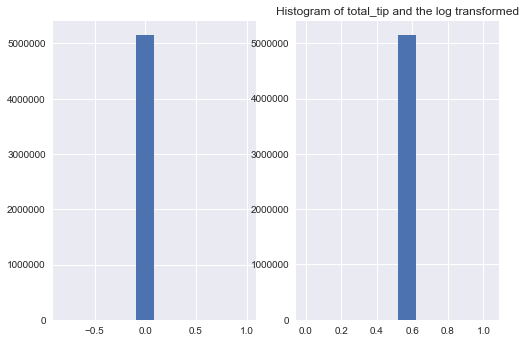

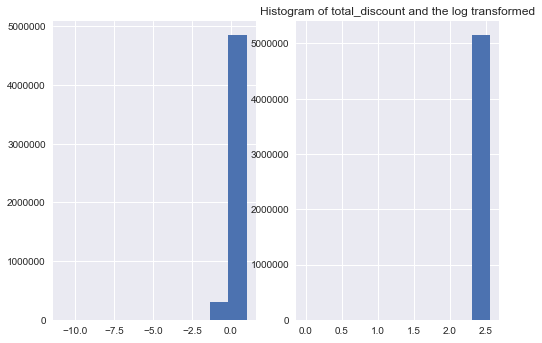

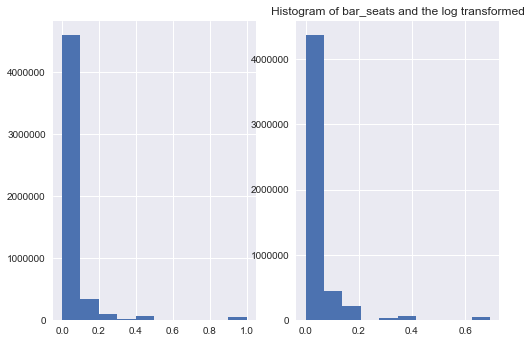

In [33]:
### Distributions of each variable

plt.subplot(121)
df_bills['total_tip'].hist()
plt.subplot(122) 
plt.hist(np.log(1+df_bills['total_tip'] + np.abs(df_bills['total_tip'].min()) ))
plt.title('Histogram of total_tip and the log transformed')
plt.show()

plt.subplot(121)
df_bills['total_discount'].hist()
plt.subplot(122) 
plt.hist(np.log(1+df_bills['total_discount'] - df_bills['total_discount'].min()))
plt.title('Histogram of total_discount and the log transformed')
plt.show()
         
plt.subplot(121)
df_bills['bar_seats'].hist()
plt.subplot(122) 
plt.hist(np.log(1+df_bills['bar_seats'] - df_bills['bar_seats'].min()))
plt.title('Histogram of bar_seats and the log transformed')
plt.show()
       


It seems that distributions of some variables are highly skewed (with absolute skewness value larger than 5), like ***total_tip, total_discount, bar_seats, Area_Ireland, Area_North East, Area_Northern Ireland, Area_Wales and rating_F***.

In [78]:
## log transform
df_bills3 = df_bills.copy()
df_bills3['total_tip'] = np.log(1+df_bills3['branch_number'] + np.abs(df_bills3['branch_number'].min()))
df_bills3['total_discount'] = np.log(1+df_bills3['guest_check_number'] + np.abs(df_bills3['guest_check_number'].min()))
df_bills3['bar_seats'] = np.log(1+df_bills3['total_covers'] + np.abs(df_bills3['total_covers'].min()))


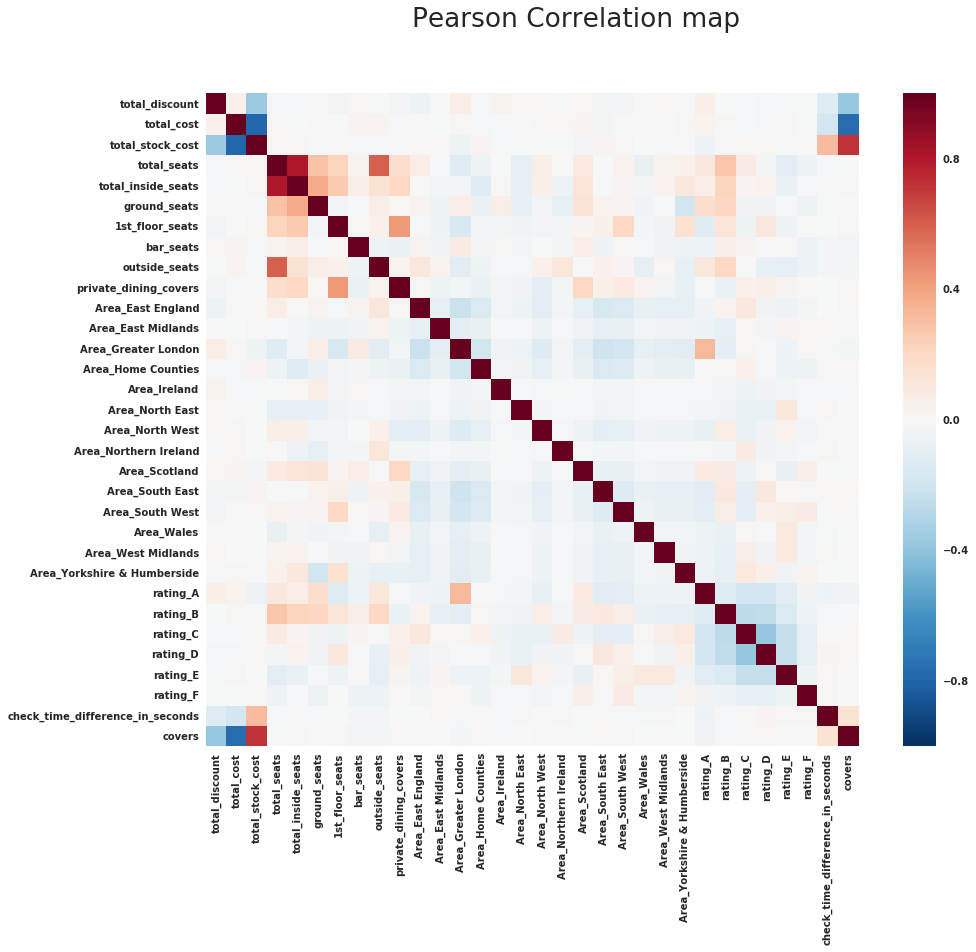

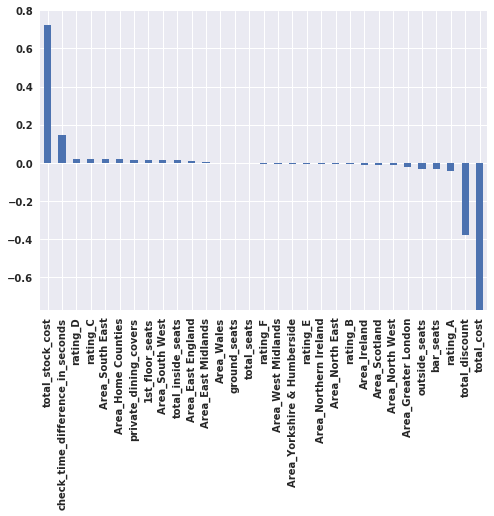

In [26]:
### correlation
pd.set_option('precision', 2)
plt.figure(figsize=(16, 12))
sns.heatmap(df_bills.corr(), square = True)
plt.suptitle('Pearson Correlation map')
plt.show()

# correlation between 'total_covers' and different features
cor_with_totalcover = df_bills.corr()['covers'].sort_values(ascending=False)
cor_with_totalcover.drop('covers').plot.bar()
plt.show()

del cor_with_totalcover


It seems that `total_stock_cost` and `check_time_difference_in_seconds`, `total_discount` and `total_cost` are highly correlated to the target variable `covers`.

Also one should note that explanatory variables `total_cost` and `total_stock_cost`, `total_seats` and `outside_seats` and `total_inside_seats`, `private_dining_covers` and `1st_floor_seats` are highly correlated.

In [16]:
# pca reduce dimensionality
# ------ code for normalized data
## drop three variables that seems totally independent with target variable
df_bills2 = df_bills.copy()
df_bills2.drop('Area_Wales', axis=1,inplace=True)
df_bills2.drop('ground_seats', axis=1, inplace=True)
df_bills2.drop('total_seats', axis=1, inplace=True)

pca_data, y_pca = df_bills2.drop('covers', axis=1), df_bills2[['covers']] 
pca = PCA(whiten=True)
pca.fit(df_bills2.drop('covers', axis=1))
variance = pd.DataFrame(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

pca_best = PCA(n_components=23, whiten=True)
pca_best_mod = pca_best.fit(pca_data)
X_pca_t = pca_best_mod.transform(pca_data)

[ 0.16389946  0.28582932  0.39552007  0.47959966  0.55838149  0.62909826
  0.69338453  0.73994462  0.78094677  0.81766648  0.84704272  0.87273382
  0.89617782  0.91798749  0.93678559  0.95089911  0.96289212  0.97034845
  0.97684483  0.98167363  0.9860915   0.98989074  0.99309622  0.9955644
  0.99786323  0.99894861  0.99996869  0.99998527  0.9999991   1.        ]


To obtain more than 99 percent of all variance, 23 variables should be kept.

In [17]:
## drop one of collinear variables.
#df_bills3 = df_bills.drop(['total_net_sales'], axis=1, errors="ignore")
#df_bills3 = df_bills.drop(['concept_number'], axis=1, errors='ignore')

# ------ code for normalized data
import random
random.seed(137)
## sample 1 percent (i.e. about 50 thousands) since the whole dataset is too large and runs too long time
n = y_pca.shape[0]
sample_ind = random.sample(y_pca.index, n*1/100)

X_pca_sample2p, y_pca_sample2p = pd.DataFrame(X_pca_t).iloc[sample_ind, ], pd.DataFrame(y_pca).iloc[sample_ind, ]
print('pca sample size: ', X_pca_sample2p.shape)

X_sample2p, y_sample2p = df_bills2.drop('covers', axis=1).iloc[sample_ind, ],  df_bills2[['covers']].iloc[sample_ind, ]
print('all sample size:', X_sample2p.shape)


## train_test_split

# 30% test set, 70% train set
X_pca_train, X_pca_test, y_pca_train, y_pca_test = \
   train_test_split(X_pca_sample2p, y_pca_sample2p, test_size=.3, random_state=5)
X_train, X_test, y_train, y_test = \
   train_test_split(X_sample2p, y_sample2p, test_size=.3, random_state=5)


print('PCA sample train X and y size: ', X_pca_train.shape, y_pca_train.shape)
print('pca sample test X and y size: ', X_pca_test.shape, y_pca_test.shape)
print('original sample train X and y size: ',X_train.shape, y_train.shape)

print(X_train.info())
print(X_test.info())

pca sample size:  (51516, 23)
all sample size: (51516, 30)
PCA sample train X and y size:  (36061, 23) (36061, 1)
pca sample test X and y size:  (15455, 23) (15455, 1)
original sample train X and y size:  (36061, 30) (36061, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36061 entries, 4467393 to 966540
Data columns (total 30 columns):
total_gross_sales                   36061 non-null float64
total_tip                           36061 non-null float64
total_discount                      36061 non-null float64
total_cost                          36061 non-null float64
total_stock_cost                    36061 non-null float64
total_inside_seats                  36061 non-null float64
1st_floor_seats                     36061 non-null float64
bar_seats                           36061 non-null float64
outside_seats                       36061 non-null float64
private_dining_covers               36061 non-null float64
Area_East England                   36061 non-null float64
Area_Ea

CV results for pca transformed data: 
Scaled_Ridge R2 score: 0.224828 +/- 0.010719
Scaled_Lasso R2 score: -0.000127 +/- 0.000207
Scaled_ElasticNet R2 score: 0.213038 +/- 0.010035
Scaled_RF R2 score: 0.572176 +/- 0.014577
Scaled_ET R2 score: 0.521198 +/- 0.017545
Scaled_BR R2 score: 0.572135 +/- 0.012488
CV results for original data: 
Scaled_Ridge R2 score: 0.722971 +/- 0.040880
Scaled_Lasso R2 score: 0.371446 +/- 0.007077
Scaled_ElasticNet R2 score: 0.715700 +/- 0.035912
Scaled_RF R2 score: 0.770040 +/- 0.011534
Scaled_ET R2 score: 0.768364 +/- 0.013952
Scaled_BR R2 score: 0.769473 +/- 0.012038


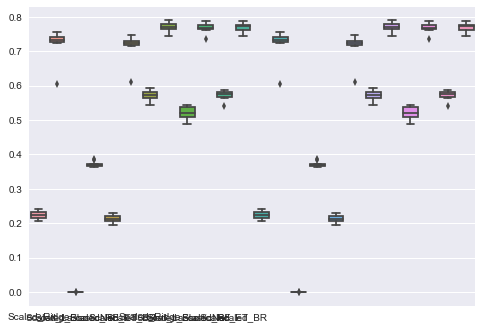

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   30.0s finished


-1.02925158148 {'RF__max_depth': 7, 'RF__min_samples_leaf': 0.04, 'RF__n_estimators': 50}
RF rmse is 2.1588 and r2 is 0.6509


In [35]:
## May take a long time (hours)
mods = [      ("Scaled_Ridge", Pipeline([("Scaler", StandardScaler()), \
                                ("Ridge", Ridge(random_state=5))])), \
              ("Scaled_Lasso", Pipeline([("Scaler", StandardScaler()), \
                                ("Lasso", Lasso(random_state=5))])), \
              ("Scaled_ElasticNet", Pipeline([("Scaler", StandardScaler()), \
                                ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.7))])),\
             
             # ("Scaled_SVR",   Pipeline([("Scaler", StandardScaler()),\   # SVR takes very long time
             #                 ("svr", SVR(kernel='rbf'))])) ,\
              ("Scaled_RF",    Pipeline([("Scaler", StandardScaler()),\
                                ("RF", RandomForestRegressor(random_state=5))])),\
              ("Scaled_ET",    Pipeline([("Scaler", StandardScaler()),\
                                ("ET", ExtraTreesRegressor(random_state=5))])),\
              ("Scaled_BR",    Pipeline([("Scaler", StandardScaler()),\
                                ("BR", BaggingRegressor(random_state=5))])) 
       ]

res, names = [ ], [ ]
print('CV results for pca transformed data: ')
for name, mod in mods:
    #use 10-fold CV
    kf = KFold(n_splits=10, shuffle=True, random_state=5)
    cv_res = cross_val_score(mod, X_pca_sample2p, y_pca_sample2p, cv=kf, scoring='r2', n_jobs=1)
    names.append(name)
    res.append(cv_res)
    print("%s R2 score: %f +/- %f" % (name, cv_res.mean(), cv_res.std()))

print('CV results for original data: ')
for name, mod in mods:
    #use 10-fold CV
    kf = KFold(n_splits=10, shuffle=True, random_state=5)
    cv_res = cross_val_score(mod, X_sample2p, y_sample2p, cv=kf, scoring='r2', n_jobs=1)
    names.append(name)
    res.append(cv_res)
    print("%s R2 score: %f +/- %f" % (name, cv_res.mean(), cv_res.std()))
    
    
    
# draw R2
sns.boxplot(pd.DataFrame(np.array(res).T, columns = names))
plt.show()

## explore RF models
scaled_RF = mods[3][1]
param_grid_rf = [{'RF__n_estimators':[50],
                 'RF__max_depth': np.arange(5,15,2),
                 'RF__min_samples_leaf':[0.04] } ]
grid_rf = GridSearchCV(estimator=scaled_RF, param_grid=param_grid_rf,
                      scoring='neg_mean_squared_error',
                      cv = KFold(n_splits=3, random_state=5, shuffle=True),
                      verbose=1)
grid_rf.fit(X_train, y_train)
print(grid_rf.best_score_, grid_rf.best_params_)
bestmod = grid_rf.best_estimator_

from sklearn.metrics import r2_score
y_pred = bestmod.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test.values)**2))
r2 = r2_score(y_test, y_pred)
print('RF rmse is %.4f and r2 is %.4f' % (rmse, r2))


For sampled pca transformed data, it seems that ***random forest, bagging regression, extratree regression*** work well.
For original sampled data, Ridge, all six methods perform better than that on pca transformed data. Moreover, Elastic net and Lasso works much better than that of pca transformed data, however, they still perform worse than randomforest, bagging and extratree.


For the whole data,
Ridge has a R2 score around 0.71 on data without PCA dimension reduction.
ExtraTreeRegressor has a R2 score around 0.74 on data after PCA transformation with 18 input variables kept.
Scaled_BR R2 score: 0.744601  on data after PCA transformation with 10 input variables kept.

It seems that Random forest perform better than other methods on both data.

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForest rmse is: 2.2820 and r2 is 0.7815


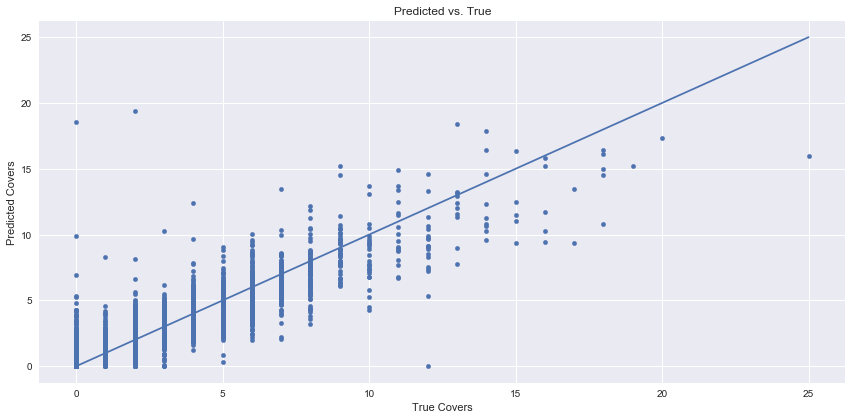

In [20]:
# random forest
#print y_test

rf = RandomForestRegressor(n_estimators=500, n_jobs=4)
rf.fit(X_train.values, y_train.values)
y_pred = rf.predict(X_test.values)

rmse = np.sqrt(np.mean((y_pred - y_test.values)**2))
r2 = r2_score(y_test, y_pred)
print('RandomForest rmse is: %.4f and r2 is %.4f' % (rmse, r2))



# plot predicted vs. true
plt.figure(figsize=(12, 6))
plt.scatter(y_test.values, y_pred, s=20)
plt.title('Predicted vs. True')
plt.xlabel('True Covers')
plt.ylabel('Predicted Covers')

#
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)])
plt.tight_layout()
plt.show()

/Library/Python/2.7/site-packages/xgboost-0.6-py2.7.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)


xgboost rmse is: 2.2154 and r2 is 0.7624


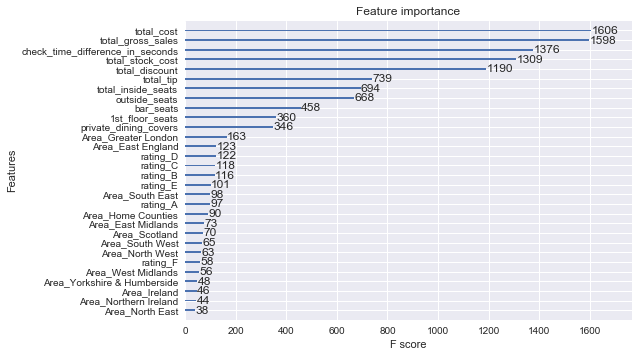

In [18]:
# xgboost
from sklearn.metrics import r2_score
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=5,
                 silent=1)

regr.fit(X_train, y_train)

# Run prediction on test set to get a rough idea of how well it does.
y_pred = regr.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test.values)**2))
r2 = r2_score(y_test, y_pred)
print('xgboost rmse is: %.4f and r2 is %.4f' % (rmse, r2))

xgb.plot_importance(regr)
plt.show()


In [ ]:
## svr
# use 10-fold CV

from sklearn import svm
parameters = {'kernel':('rbf'), 'C':[1, 10]}
svr = svm.SVR()

grid = GridSearchCV(svr, parameters, cv=KFold(n_splits=10, random_state=5, shuffle=True))
grid=grid.fit(X_train, y_train)
svr = grid.best_estimator_  

from sklearn.metrics import r2_score
y_pred = svr.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
r2 = r2_score(y_test, y_pred)
print 'SVR rmse is %.4f and r2 is %.4f' % (rmse, r2)

# the GridSearchCV takes too long time to finish

XGboost works similar with random forest, having a R2 of 0.76.
It is clear that *** total_cost, total_gross_sales, check_time_difference_in_seconds, total_stock_cost, total_discount *** are important indicators for predicting covers.

SVR rmse is: 2.1588 and r2 is 0.6509


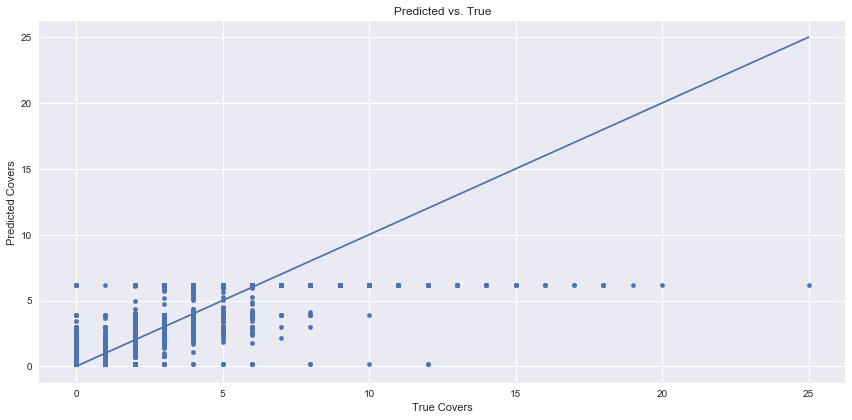

In [27]:
# svr no grid cv search 
svr = SVR(kernel='rbf', C=5, epsilon=0.3)
svr.fit(X_train, y_train)

pred = svr.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test.values)**2))
r2 = r2_score(y_test, y_pred)
print 'SVR rmse is: %.4f and r2 is %.4f' % (rmse, r2)

# plot predicted vs. true
plt.figure(figsize=(12, 6))
plt.scatter(y_test.values, y_pred, s=20)
plt.title('Predicted vs. True')
plt.xlabel('True Covers')
plt.ylabel('Predicted Covers')

#
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)])
plt.tight_layout()
plt.show()


Neural Network rmse is: 2.2533 and r2 is 0.7353


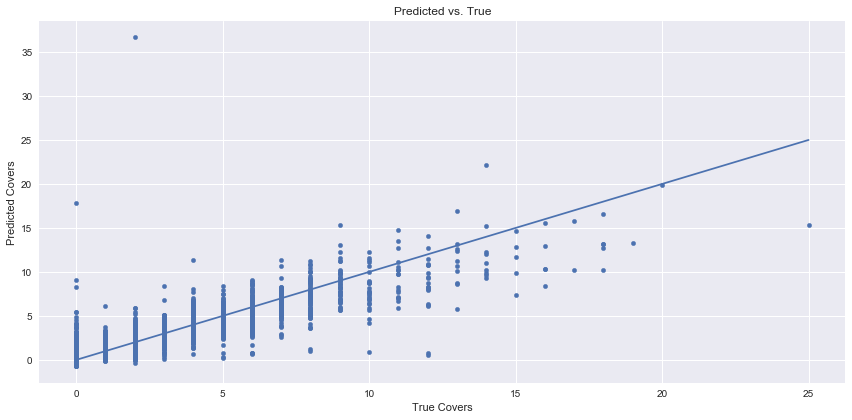

In [29]:
### neural network
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
rmse = np.sqrt(np.mean((y_pred - y_test.values)**2))
r2 = r2_score(y_test, y_pred)
print 'Neural Network rmse is: %.4f and r2 is %.4f' % (rmse, r2)

# plot predicted vs. true
plt.figure(figsize=(12, 6))
plt.scatter(y_test.values, y_pred, s=20)
plt.title('Predicted vs. True')
plt.xlabel('True Covers')
plt.ylabel('Predicted Covers')

#
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)])
plt.tight_layout()
plt.show()

Neural Network works much better than SVR, but seems a little worse than both RF and XGBooost.

In [ ]:
## deep learning 
import tflearn
import tensorflow as tf
import seaborn
import warnings
warnings.filterwarnings('ignore')


# Shape the labels
labels_nl = y_train
labels_nl = labels_nl.values.reshape(-1, 1)

tf.reset_default_graph()

net = tflearn.input_data(shape=[None, X_train.shape[1]])
net = tflearn.fully_connected(net, 10, activation='linear')
net = tflearn.fully_connected(net, 1, activation='linear')
sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.01, decay_step=100)
net = tflearn.regression(net, optimizer=sgd,loss='mean_square',metric=tflearn.R2())
model = tflearn.DNN(net)

model.fit(X_train, labels_nl,show_metric=True,validation_set=0.2,shuffle=True,n_epoch=50)



---------------------------------
Run id: T18WCP
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name StandardError/ (raw) is illegal; using StandardError/__raw_ instead.
---------------------------------
Training samples: 28848
Validation samples: 7213
--


Exception in thread Thread-104:
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/Library/Python/2.7/site-packages/tflearn/data_flow.py", line 187, in fill_feed_dict_queue
    data = self.retrieve_data(batch_ids)
  File "/Library/Python/2.7/site-packages/tflearn/data_flow.py", line 222, in retrieve_data
    utils.slice_array(self.feed_dict[key], batch_ids)
  File "/Library/Python/2.7/site-packages/tflearn/utils.py", line 187, in slice_array
    return X[start]
  File "/Library/Python/2.7/site-packages/pandas/core/frame.py", line 2053, in __getitem__
    return self._getitem_array(key)
  File "/Library/Python/2.7/site-packages/pandas/core/frame.py", line 2098, in _getitem_array
    return self.take

Anyway, the deep learning package tflearn seems not easy to use and doest not work.